## Bài tập thực hành Biến hình và xử lý ảnh 02
## MSSV: 18110014 - Họ tên: Nguyễn Phú Thành

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from PIL import Image
import skfuzzy as fuzz
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

In [2]:
def imShows(Images, Labels = None, rows = 1, cols = 1):
    imagesArray = list(Images)
    labelsArray = [f"Image {i + 1}" for i in range(len(imagesArray))] if Labels is None else list(Labels)
    figsize = (14, 12) if ((rows == 1) and (cols == 1)) else (cols * 8, rows * 5)
    fig = plt.figure(figsize = figsize)
    for i in range(1, rows * cols + 1):
        ax = fig.add_subplot(rows, cols, i)
        image = imagesArray[i - 1]
        cmap = plt.cm.gray if (len(image.shape) < 3) else None
        ax.imshow(image, cmap = cmap)
        ax.set(title = labelsArray[i - 1], xticks = [], yticks = [])
    plt.show()

In [3]:
def fromDirectory(path, extension = '.jpg'):
    current_path = os.getcwd()
    os.chdir(path)
    
    image_dicts = dict()
    
    for file in os.listdir():
        if file.endswith(extension):
            image_dicts.setdefault(file, 0)
            if extension == '.png':
                with Image.open(file) as img:
                    image_dicts[file] = np.asarray(img.convert('RGB'))
            else:
                image_dicts[file] = plt.imread(file)
    os.chdir(current_path)
    return image_dicts

In [4]:
image_dicts = dict()

for ext in ['.jpg', '.jpeg', '.png']:
    imgs = fromDirectory('Object Segmentation Data', extension = ext)
    image_dicts.update(imgs)

In [5]:
def segmentFromMask(img, mask, mask_val = 1):
    if len(img.shape) == 2:
        return np.where(mask == mask_val, img, 0)
    else:
        result_segment = np.zeros(img.shape, dtype = img.dtype)
        for channel in range(len(img.shape)):
            result_segment[:, :, channel] = np.where(mask == mask_val, img[:, :, channel], 0)
        return result_segment

# 1/ Thực hiện lại các thao tác trong phần hướng dẫn và tìm cách sử dụng không gian màu HSV hay Lab để filter các vùng có màu da, màu lá hay màu quan tâm để thay thế bước dùng point xác định vị trí index cần quan tâm

##  KMeans Clustering

In [6]:
def KMeansClustering(img, max_iteration, epsilon, number_clusters):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iteration, epsilon)
    vectorized_img = img.reshape((-1, len(img.shape))).astype(np.float32)
    ret, label, center = cv2.kmeans(
        vectorized_img, 
        number_clusters, 
        None, 
        criteria, 
        max_iteration, 
        cv2.KMEANS_PP_CENTERS
    )
    result_label = label.reshape(img.shape[:2])
    result_img = center.astype(np.uint8)[label.flatten()].reshape(img.shape)
    
    return result_label, result_img

In [7]:
img_orig = image_dicts['Emotion.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

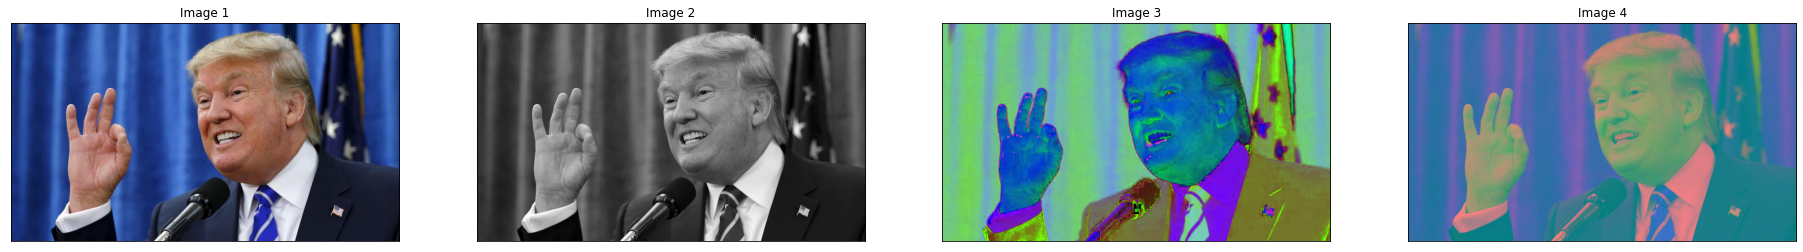

In [8]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [9]:
label, clusters = KMeansClustering(img_hsv, max_iteration = 100, epsilon = 1, number_clusters = 4)

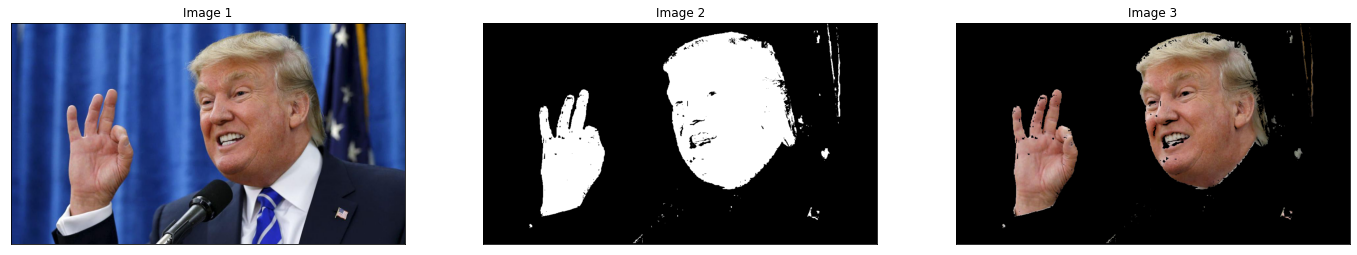

In [10]:
mask = (label == 1).astype(np.uint8)
emotion = segmentFromMask(img_orig, mask)
imShows([img_orig, mask, emotion], rows = 1, cols = 3)

In [11]:
morph_mask = cv2.erode(
    cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 1), dtype = np.uint8), iterations = 20),
    np.ones((3, 3)),
    iterations = 7
)

In [12]:
cropMask = np.zeros(morph_mask.shape, dtype = np.uint8)
cropMask[:, 500:] = morph_mask[:, 500:]

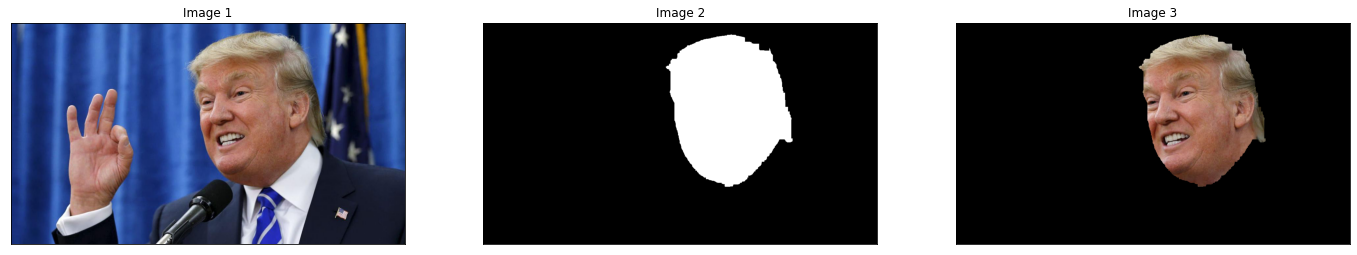

In [13]:
emotion = segmentFromMask(img_orig, cropMask)
imShows([img_orig, cropMask, emotion], rows = 1, cols = 3)

## Sử dụng không gian màu HSV hay Lab để filter các vùng có màu da

In [14]:
mask_hsv = cv2.inRange(img_hsv, (0, 15, 0), (17, 170, 255))
mask_ycrcb = cv2.inRange(img_ycbr, (0, 135, 85), (255, 180, 135))

In [15]:
imShows([mask_hsv, mask_ycrcb], rows = 1, cols = 2)

## Fuzzy C Means Clustering

In [16]:
img_orig = image_dicts['Bone.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

In [17]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [18]:
def fuzzyCMeans(img, number_clusters, error = 1e-3, maxiter = 1000, metric = 'euclidean', seed = 0):
    
    if len(img.shape) == 3:
        data = img.reshape((img.shape[0] * img.shape[1], 3)).astype(np.uint8)
    else:
        data = img.reshape((img.shape[0] * img.shape[1], 1)).astype(np.uint8)
    
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data.T, 
        number_clusters,
        2,
        error,
        maxiter,
        metric = metric,
        init = None,
        seed = seed
    )
    new_img = []
    for pix in u.T:
        new_img.append(cntr[np.argmax(pix)])
    
    if len(img.shape) == 3:
        return np.array(new_img).reshape(img.shape).astype(np.uint8)[:, :, 1]
    else:
        return np.array(new_img).reshape(img.shape).astype(np.uint8)

In [19]:
result_label = fuzzyCMeans(img_orig, number_clusters = 5, maxiter = 1000, error = 1e-4)

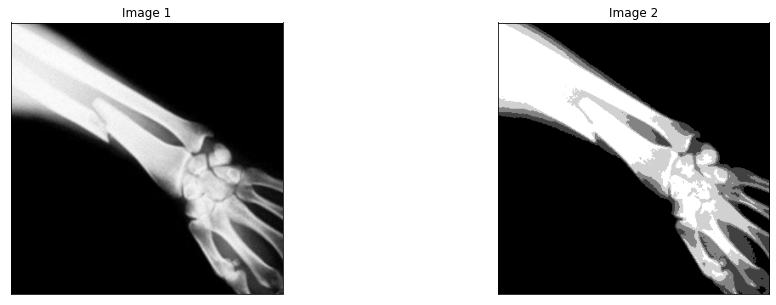

In [20]:
imShows([img_orig, result_label], rows = 1, cols = 2)

In [21]:
clahe = cv2.createCLAHE(clipLimit = 35, tileGridSize = (7, 6))
cl1 = clahe.apply(img_gray)

In [22]:
result_label = fuzzyCMeans(cl1, number_clusters = 2)

In [23]:
mask = (result_label == 186).astype(np.uint8)
bones = segmentFromMask(img_orig, mask)

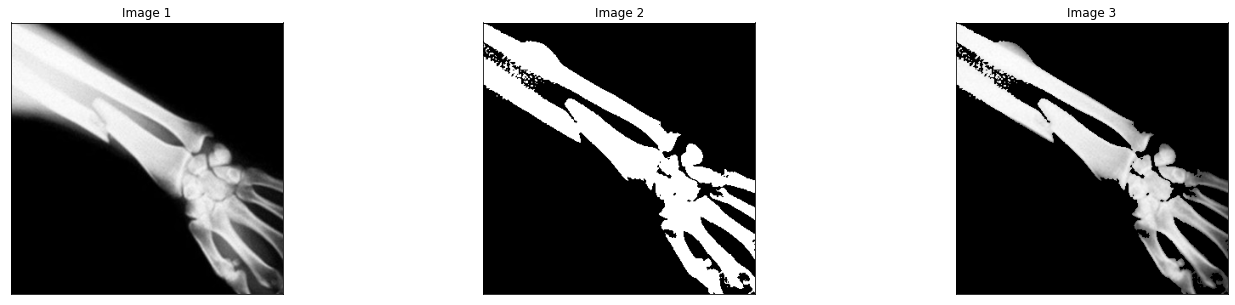

In [24]:
imShows([img_orig, mask, bones], rows = 1, cols = 3)

## Meanshift

In [25]:
img_orig = cv2.resize(image_dicts['Cloths.jpg'], (200, 200), interpolation = cv2.INTER_AREA)
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

In [26]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [27]:
bandwidth = estimate_bandwidth(img_orig.reshape((-1, 3)), quantile = 0.15, n_samples = 100, random_state = 0)

In [28]:
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True).fit(img_orig.reshape((-1, 3)))

In [29]:
result_label = ms.labels_.reshape(img_orig.shape[:2])

In [30]:
mask = (~(result_label == 0)).astype(np.uint8)

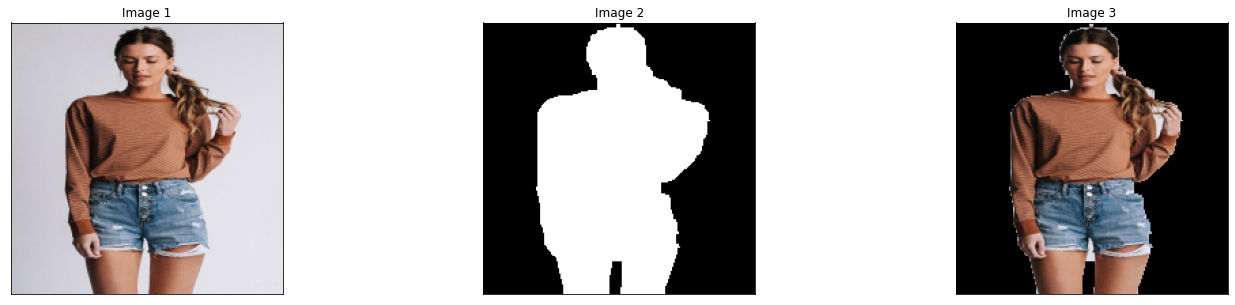

In [31]:
morph_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations = 3)
model = segmentFromMask(img_orig, morph_mask)
imShows([img_orig, morph_mask, model], rows = 1, cols = 3)

## Hierachy Clustering

In [32]:
img_orig = cv2.resize(image_dicts['Leaf.jpg'], (200, 200), interpolation = cv2.INTER_AREA)
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

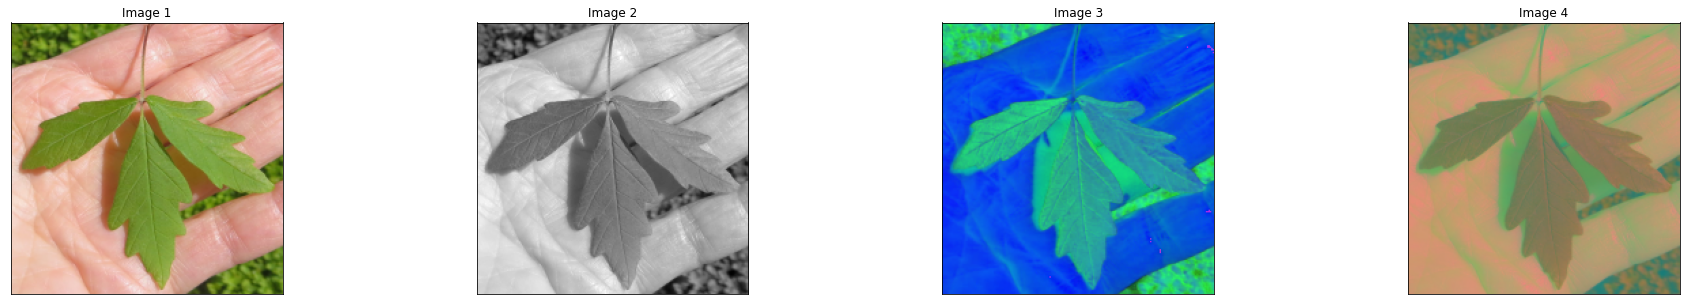

In [33]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [34]:
hue_channel = img_hsv[:, :, 0].copy()

In [35]:
connectivity = grid_to_graph(*hue_channel.shape)
X = hue_channel.reshape((-1, 1))

In [36]:
n_clusters = 5
ward = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward', connectivity = connectivity)
ward.fit(X)

AgglomerativeClustering(connectivity=<40000x40000 sparse matrix of type '<class 'numpy.int64'>'
	with 199200 stored elements in COOrdinate format>,
                        n_clusters=5)

In [37]:
result_label = ward.labels_.reshape(hue_channel.shape)

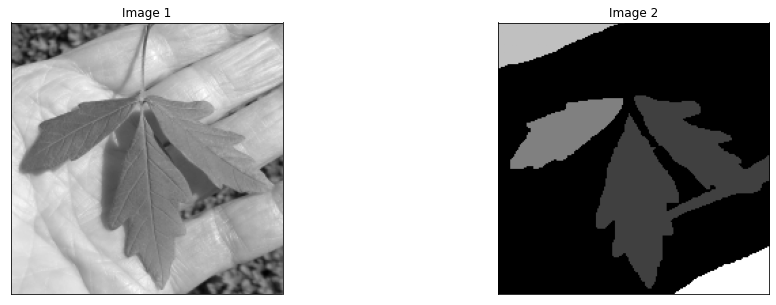

In [38]:
imShows([img_gray, result_label], rows = 1, cols = 2)

In [39]:
mask = ((result_label == 1) + (result_label == 2)).astype(np.uint8)

In [40]:
transform_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3)), iterations = 4)

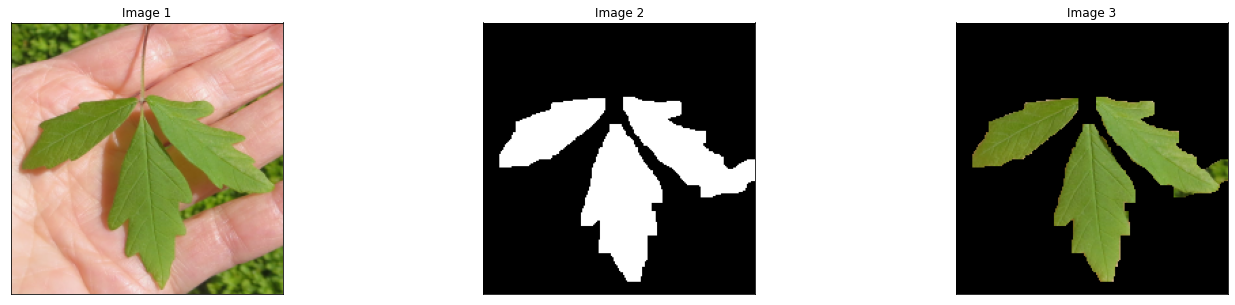

In [41]:
leaf = segmentFromMask(img_orig, transform_mask)
imShows([img_orig, transform_mask, leaf], rows = 1, cols = 3)

## Sử dụng không gian màu HSV hay Lab để filter các vùng có màu lá

In [42]:
mask_hsv = cv2.inRange(img_hsv, (13, 69, 53), (45, 248, 230))
mask_ycrcb = cv2.inRange(img_ycbr, (42, 113, 70), (203, 154, 113))

In [43]:
imShows([mask_hsv, mask_ycrcb], rows = 1, cols = 2)

## 2/ Chọn thêm 3 ví dụ trong danh sách hình và định nghĩa object cần segment trong các hình là gì và thực hiện segmentation tốt nhất bằng kmeans, meanshift, fuzzy cmeans, và hierachy clustering

## a) Lung.jpg
## Object cần segment: Phổi trong ảnh X Quang

In [44]:
img_orig = image_dicts['Lung.png']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

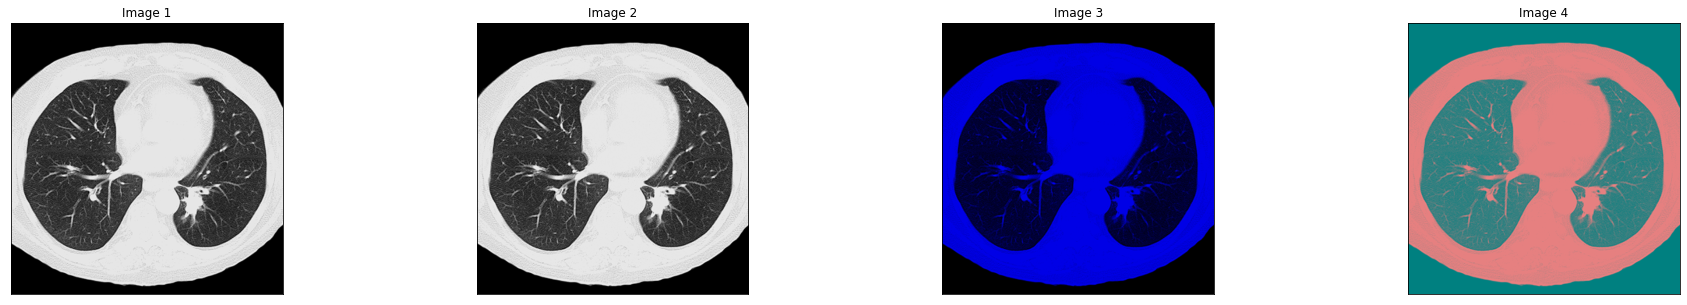

In [45]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [46]:
label, clusters = KMeansClustering(img_orig, max_iteration = 100, epsilon = 1e-2, number_clusters = 3)

In [47]:
mask = (label == 1).astype(np.uint8)

In [48]:
result_mask = cv2.erode(
    cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5)), iterations = 7),
    np.ones((5, 5)), iterations = 3
)

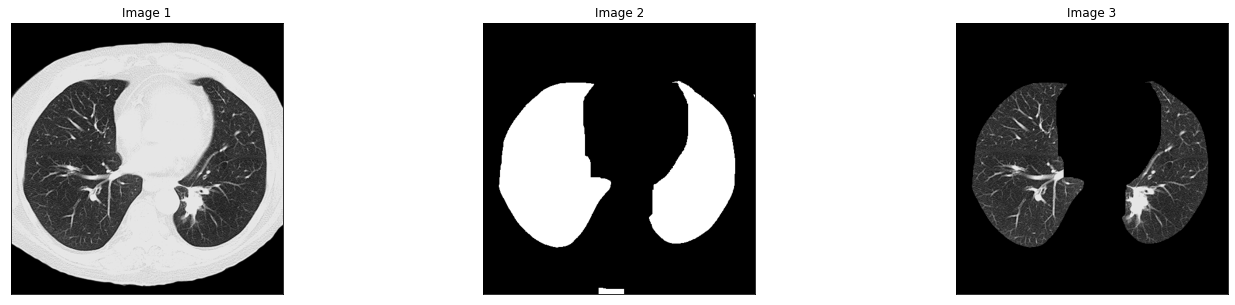

In [49]:
lung = segmentFromMask(img_orig, result_mask)
imShows([img_orig, result_mask, lung], rows = 1, cols = 3)

## b) Gesture.jpg
## Object cần segment: Bàn tay

In [50]:
img_orig = image_dicts['Gesture.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

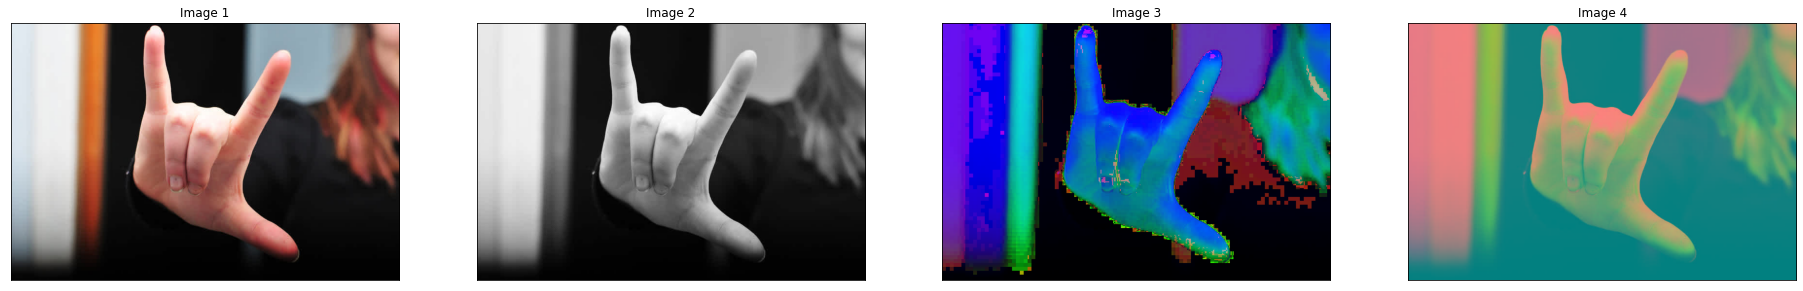

In [51]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [52]:
result_label = fuzzyCMeans(img_hsv, number_clusters = 5, maxiter = 1000, error = 1e-4)

In [53]:
mask = ((result_label == 77) + (result_label == 144)).astype(np.uint8)

In [54]:
cropMask = np.zeros(mask.shape, dtype = np.uint8)
cropMask[:, 250 : 600] = mask[:, 250 : 600]

In [55]:
resultMask = cv2.dilate(cropMask, np.ones((3, 3)), iterations = 2)

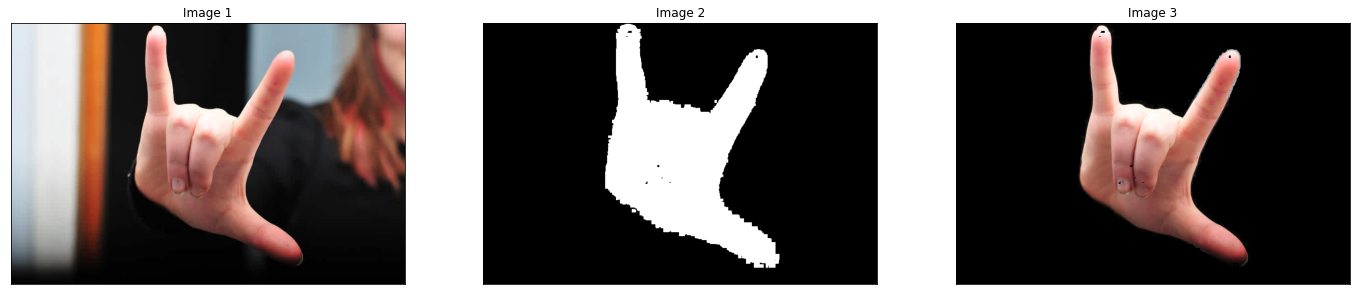

In [56]:
gesture = segmentFromMask(img_orig, resultMask)
imShows([img_orig, resultMask, gesture], rows = 1, cols = 3)

## c) Melanoma.jpg
## Object cần segment: Vết da

In [57]:
img_orig = image_dicts['Melanoma.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

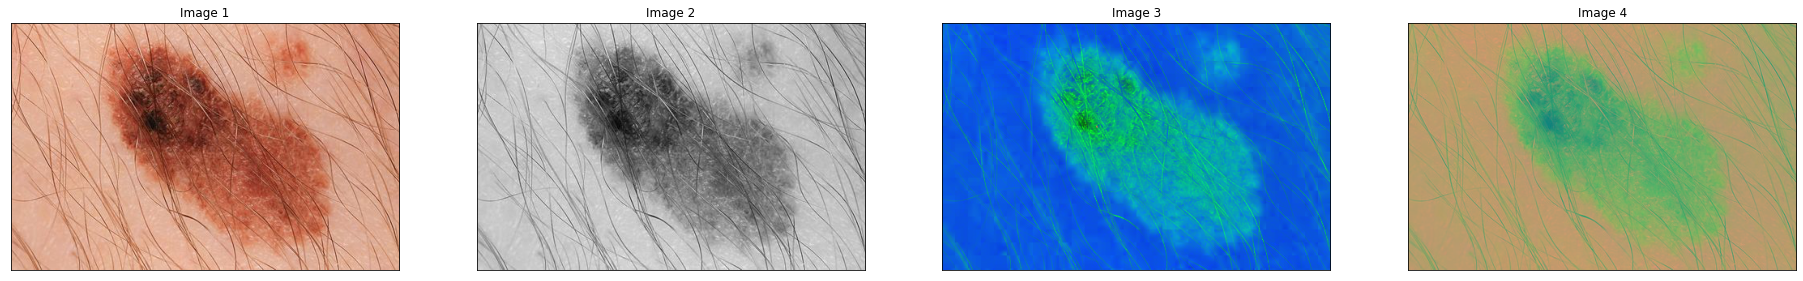

In [58]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [59]:
label, clusters = KMeansClustering(img_hsv, max_iteration = 100, epsilon = 1, number_clusters = 2)

In [60]:
mask = (label == 1).astype(np.uint8)

In [61]:
result_mask = cv2.dilate(
    cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3)), iterations = 2),
    np.ones((3, 3)), iterations = 7
)

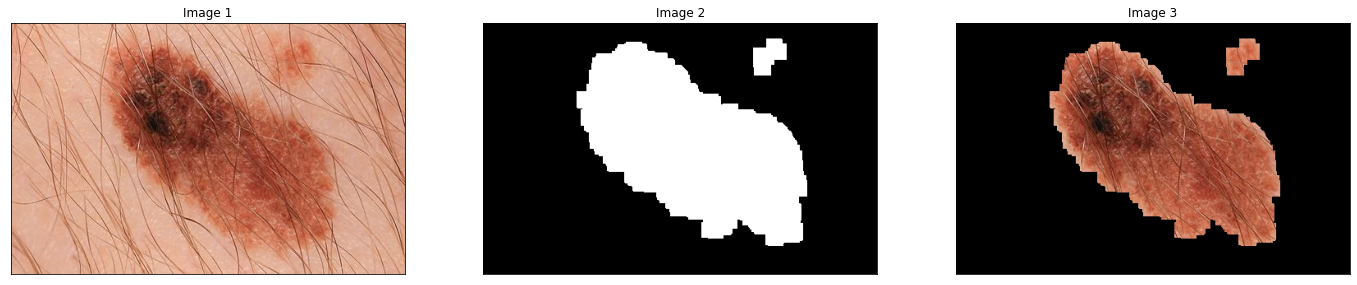

In [62]:
melanoma = segmentFromMask(img_orig, result_mask)
imShows([img_orig, result_mask, melanoma], rows = 1, cols = 3)

## ---------------------------------- Phần làm thêm ----------------------------------

## Mask.jpg
## Object cần segment: Khẩu trang

In [63]:
img_orig = image_dicts['Mask.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

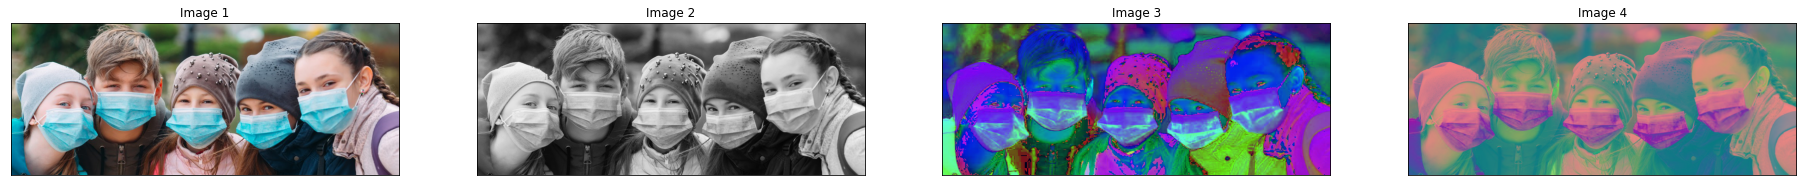

In [64]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [65]:
result_label = fuzzyCMeans(img_ycbr[:, : ,1], number_clusters = 2, maxiter = 1000, error = 1e-4)

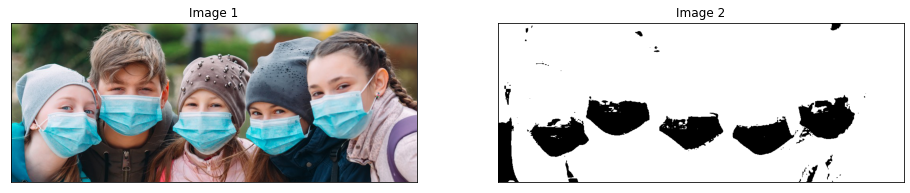

In [66]:
imShows([img_orig, result_label], rows = 1, cols = 2)

In [67]:
mask = (result_label == 82).astype(np.uint8)

In [68]:
cropMask = np.zeros(mask.shape, dtype = np.uint8)
cropMask[100:, 50:] = mask[100:, 50:].copy()

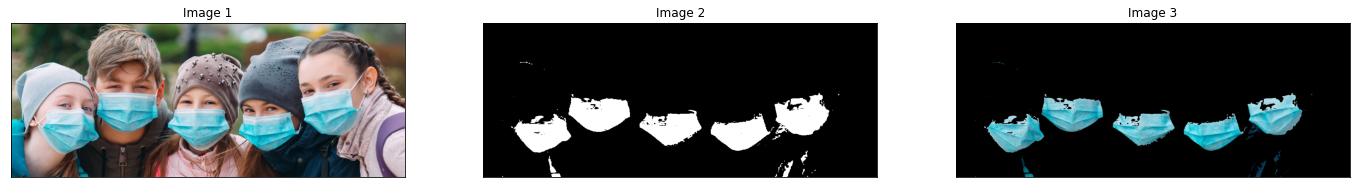

In [69]:
mask_segment = segmentFromMask(img_orig, cropMask)
imShows([img_orig, cropMask, mask_segment], rows = 1, cols = 3)

## Hand.jpg
## Object cần segment: Bàn tay

In [70]:
img_orig = image_dicts['Hand.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

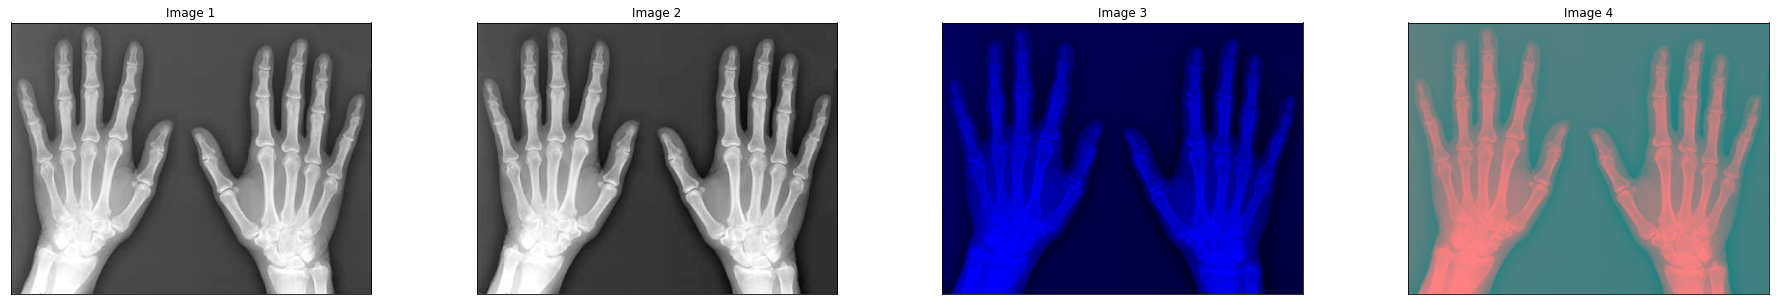

In [71]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [72]:
label, clusters = KMeansClustering(img_orig, max_iteration = 100, epsilon = 1e-2, number_clusters = 3)

In [73]:
mask = np.bitwise_not((label == 0)).astype(np.uint8)

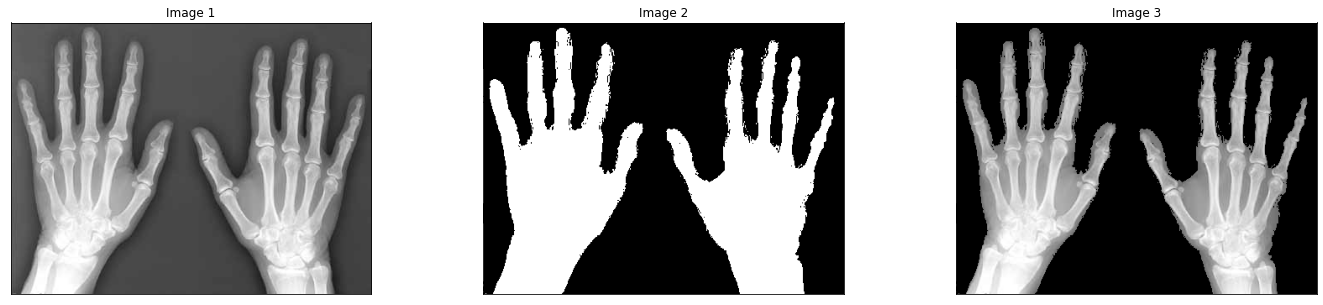

In [74]:
hand = segmentFromMask(img_orig, mask)
imShows([img_orig, mask, hand], rows = 1, cols = 3)

## QR.jpg
## Object cần segment: Mã QR

In [75]:
img_orig = image_dicts['QR.jpg']
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_hsv = cv2.cvtColor(img_orig, cv2.COLOR_RGB2HSV)
img_ycbr = cv2.cvtColor(img_orig, cv2.COLOR_RGB2YCR_CB)

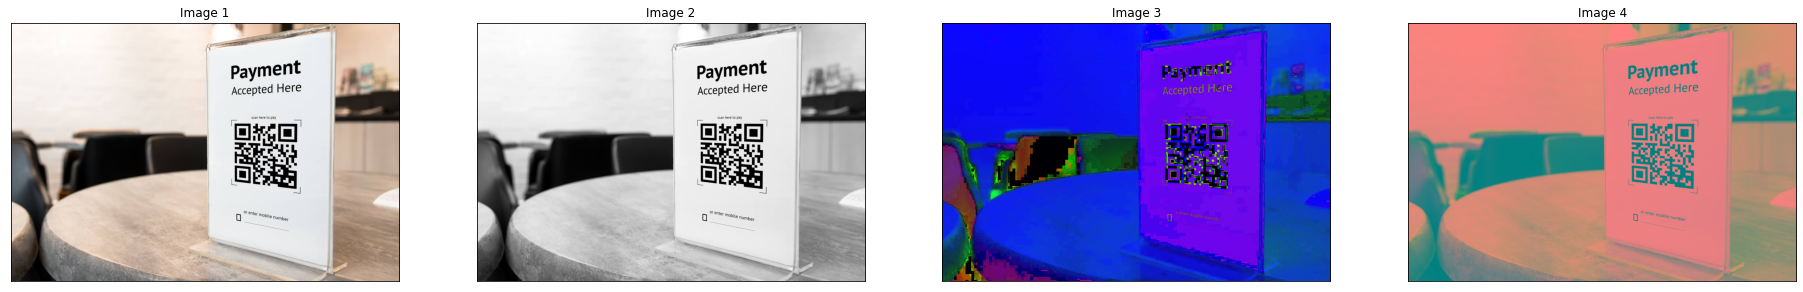

In [76]:
imShows([img_orig, img_gray, img_hsv, img_ycbr], rows = 1, cols = 4)

In [77]:
label, clusters = KMeansClustering(img_orig, max_iteration = 100, epsilon = 1e-2, number_clusters = 4)

In [78]:
mask = (label == 0).astype(np.uint8)
cropMask = np.ones(mask.shape, dtype = np.uint8)
cropMask[200:1200, 1100:1600] = mask[200:1200, 1100:1600].copy()

In [79]:
imShows([img_orig, cropMask], rows = 1, cols = 2)